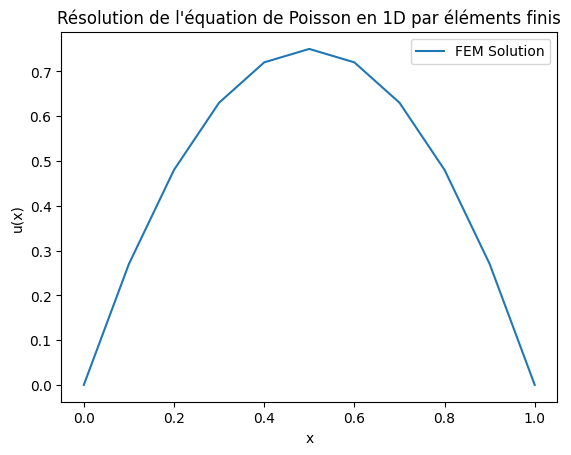

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Paramètres
L = 1.0  # Longueur du domaine
N = 10   # Nombre d'éléments finis
h = L / N  # Taille de chaque élément

# Coordonnées des noeuds
x = np.linspace(0, L, N+1)

# Fonction source
def f(x):
    return -6.0

# Matrice de rigidité et vecteur de charge
A = np.zeros((N+1, N+1))
b = np.zeros(N+1)

# Assemblage de la matrice de rigidité et du vecteur de charge
for i in range(1, N):
    A[i, i-1] += 1/h
    A[i, i] += -2/h
    A[i, i+1] += 1/h
    b[i] += f(x[i]) * h

# Conditions aux limites
A[0, 0] = A[N, N] = 1.0
b[0] = b[N] = 0.0

# Résolution du système linéaire
u_fem = np.linalg.solve(A, b)

# Affichage des résultats
plt.plot(x, u_fem, label='FEM Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Résolution de l\'équation de Poisson en 1D par éléments finis')
plt.legend()
plt.show()


Epoch 0, Loss: 35.092620849609375
Epoch 100, Loss: 10.93550968170166
Epoch 200, Loss: 5.763713836669922
Epoch 300, Loss: 3.50020432472229
Epoch 400, Loss: 0.5078719258308411
Epoch 500, Loss: 0.072007916867733
Epoch 600, Loss: 0.017793215811252594
Epoch 700, Loss: 0.007061412557959557
Epoch 800, Loss: 0.004220116417855024
Epoch 900, Loss: 0.0033410736359655857


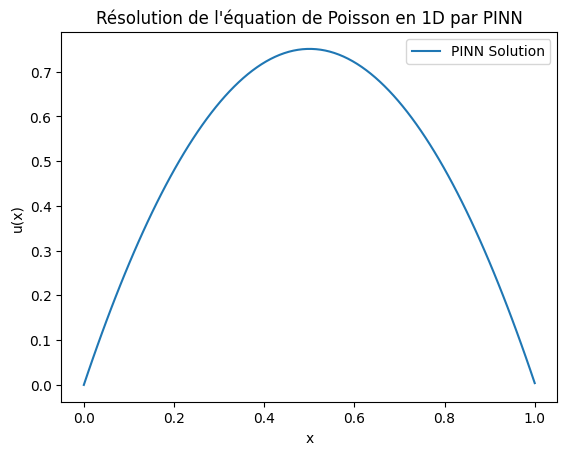

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Générer des données de formation
x_train = np.linspace(0, 1, 100).reshape(-1, 1)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)

# Définir le modèle de réseau de neurones
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(20, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(20, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1)
    
    def call(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        return self.output_layer(x)

# Définir la fonction de perte physique
def f_model(x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
    return u_xx + 6.0

# Conditions aux limites
def boundary_condition(x):
    return tf.zeros_like(x)

# Définir la perte totale
def loss(model, x):
    u_pred = model(x)
    loss_pde = tf.reduce_mean(tf.square(f_model(x)))
    loss_bc = tf.reduce_mean(tf.square(model(tf.zeros_like(x))) + tf.square(model(tf.ones_like(x))))
    return loss_pde + loss_bc

# Créer le modèle
model = PINN()

# Entraîner le modèle
optimizer = tf.keras.optimizers.Adam()
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x_train)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss_value.numpy()}')

# Prédire avec le modèle entraîné
u_pinn = model(x_train).numpy()

# Affichage des résultats
plt.plot(x_train, u_pinn, label='PINN Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Résolution de l\'équation de Poisson en 1D par PINN')
plt.legend()
plt.show()


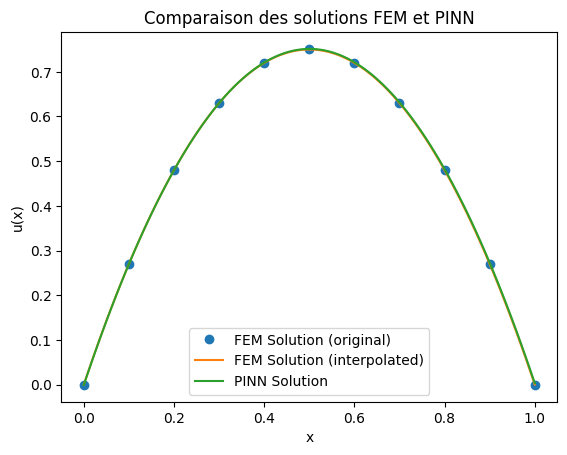

Erreur relative : 0.003019887704120599


In [18]:
# Interpoler la solution FEM pour correspondre aux points de x_train
fem_interpolator = interp1d(x, u_fem, kind='cubic')
u_fem_interpolated = fem_interpolator(x_train.numpy().flatten())

# Afficher les solutions côte à côte
plt.plot(x, u_fem, 'o', label='FEM Solution (original)')
plt.plot(x_train, u_fem_interpolated, '-', label='FEM Solution (interpolated)')
plt.plot(x_train, u_pinn, label='PINN Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Comparaison des solutions FEM et PINN')
plt.legend()
plt.show()

# Calcul de l'erreur relative
error = np.linalg.norm(u_fem_interpolated - u_pinn.flatten()) / np.linalg.norm(u_fem_interpolated)
print(f'Erreur relative : {error}')


Epoch: 0, Loss: 95.84452056884766
Epoch: 100, Loss: 14.757570266723633
Epoch: 200, Loss: 9.600488662719727
Epoch: 300, Loss: 6.61484956741333
Epoch: 400, Loss: 1.3538033962249756
Epoch: 500, Loss: 0.7052739858627319
Epoch: 600, Loss: 0.45284318923950195
Epoch: 700, Loss: 0.2196241021156311
Epoch: 800, Loss: 0.10314969718456268
Epoch: 900, Loss: 0.06379786878824234
Epoch: 1000, Loss: 0.04581823572516441
Epoch: 1100, Loss: 0.03672673925757408
Epoch: 1200, Loss: 0.030435482040047646
Epoch: 1300, Loss: 0.02550789713859558
Epoch: 1400, Loss: 0.02148096263408661
Epoch: 1500, Loss: 0.01816689968109131
Epoch: 1600, Loss: 0.01564992591738701
Epoch: 1700, Loss: 0.013474857434630394
Epoch: 1800, Loss: 0.011599188670516014
Epoch: 1900, Loss: 0.010014128871262074
Epoch: 2000, Loss: 0.00871363002806902
Epoch: 2100, Loss: 0.007769121788442135
Epoch: 2200, Loss: 0.007014753762632608
Epoch: 2300, Loss: 0.006422141566872597
Epoch: 2400, Loss: 0.005961529910564423
Epoch: 2500, Loss: 0.00560416467487812
E

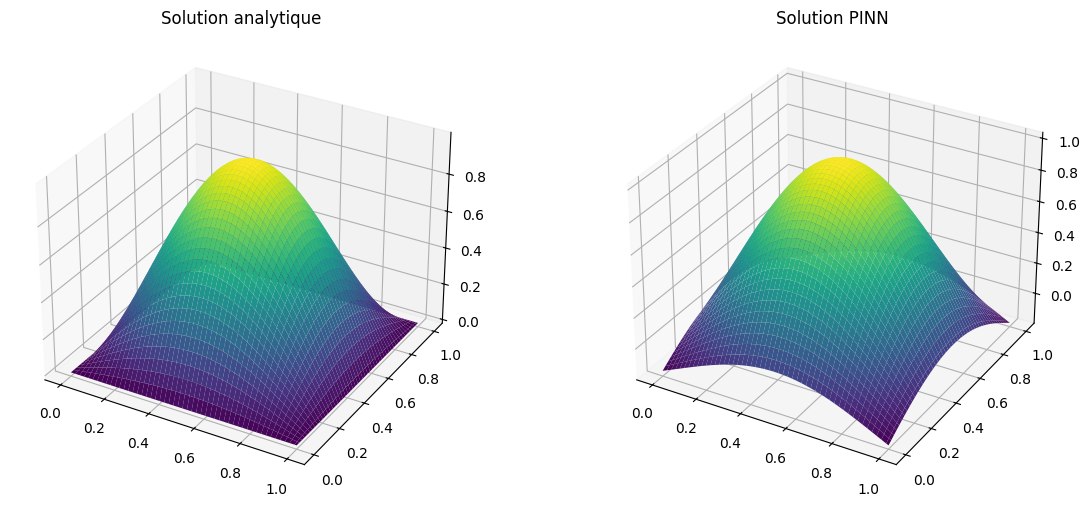

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Générer des données d'entraînement sur une grille régulière
def generate_training_data(n):
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    X, Y = np.meshgrid(x, y)
    u_analytical = np.sin(np.pi * X) * np.sin(np.pi * Y)
    return X.flatten()[:, None], Y.flatten()[:, None], u_analytical.flatten()[:, None]

# Solution analytique
def analytical_solution(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# Définir le modèle PINN
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(100, activation='tanh')
        self.hidden_layer2 = tf.keras.layers.Dense(100, activation='tanh')
        self.hidden_layer3 = tf.keras.layers.Dense(100, activation='tanh')
        self.hidden_layer4 = tf.keras.layers.Dense(100, activation='tanh')
        self.hidden_layer5 = tf.keras.layers.Dense(100, activation='tanh')
        self.hidden_layer6 = tf.keras.layers.Dense(100, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.hidden_layer5(x)
        x = self.hidden_layer6(x)
        return self.output_layer(x)

# Définir la fonction de perte
def compute_loss(model, x, y, u_analytical):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        u = model(tf.concat([x, y], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
        u_xx = tape.gradient(u_x, x)
        u_yy = tape.gradient(u_y, y)
        f = -2 * np.pi**2 * tf.sin(np.pi * x) * tf.sin(np.pi * y)
        pde_loss = tf.reduce_mean(tf.square(u_xx + u_yy - f))
        boundary_loss = tf.reduce_mean(tf.square(u - u_analytical))
        total_loss = pde_loss + boundary_loss
    return total_loss

# Entraîner le modèle
def train_model(model, x_train, y_train, u_train, epochs, optimizer):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x_train, y_train, u_train)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.numpy()}')
        # Réduction du taux d'apprentissage
        if epoch % 500 == 0 and epoch > 0:
            new_lr = optimizer.learning_rate.numpy() * 0.9
            optimizer.learning_rate.assign(new_lr)

# Générer les données
n_train = 50  # Augmentation du nombre de points
x_train, y_train, u_train = generate_training_data(n_train)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)

# Initialiser le modèle et l'optimiseur
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Entraîner le modèle
train_model(model, x_train, y_train, u_train, epochs=10000, optimizer=optimizer)

# Comparer avec la solution analytique
x_test = np.linspace(0, 1, 100)
y_test = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_test, y_test)
u_analytical = analytical_solution(X, Y)

u_pinn = model(tf.convert_to_tensor(np.c_[X.ravel(), Y.ravel()], dtype=tf.float32))
u_pinn = u_pinn.numpy().reshape(X.shape)

# Tracer les résultats
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot_surface(X, Y, u_analytical, cmap='viridis')
ax1.set_title('Solution analytique')
ax2.plot_surface(X, Y, u_pinn, cmap='viridis')
ax2.set_title('Solution PINN')

plt.show()


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import tensorflow as tf
# Lire les données depuis le fichier
file_path = 'C:/Users/TOUGERON/Documents/PRO/SMECA/Test_plaque_trou/Plate_Files/RunCase_12/Result-Stage_1/defo'
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extraire les coordonnées et les déplacements DX
coordinates = []
displacements_dx = []

reading_coordinates = False
reading_displacements = False

for line in lines:
    # Ignorer les lignes contenant 'FINSF'
    if 'FINSF' in line:
        reading_coordinates = False
        reading_displacements = False
        continue
    # Lire les coordonnées
    if line.strip().startswith('N') and not reading_displacements:
        parts = line.split()
        if len(parts) >= 4:
            try:
                x = float(parts[1])
                y = float(parts[2])
                z = float(parts[3])
                coordinates.append((x, y, z))
            except ValueError:
                print(f"Erreur de conversion pour la ligne: {line}")
    # Commencer à lire les déplacements après 'DEPL'
    elif 'DEPL' in line:
        reading_coordinates = False
        reading_displacements = True
    elif '------>' in line:
        reading_displacements = False
    # Lire les déplacements DY
    elif reading_displacements and line.strip():
        parts = line.split()
        if len(parts) >= 3:
            try:
                dx = float(parts[2])
                displacements_dx.append(dx)
            except ValueError:
                print(f"Erreur de conversion pour la ligne: {line}")

coordinates = np.array(coordinates)
coordinates = coordinates[:1281]
displacements_dx.remove(displacements_dx[0])
displacements_dx = np.array(displacements_dx)

# Afficher les premières lignes pour vérifier
print("Coordinates:", coordinates[:5])
print("Displacements DY:", displacements_dx[:5])


Erreur de conversion pour la ligne:  N1       N2       N3       N4       N5       N6       N7      

Erreur de conversion pour la ligne:  N8       N9       N10      N11      N12      N13      N14     

Erreur de conversion pour la ligne:  N15      N16      N17      N18      N19      N20      N21     

Erreur de conversion pour la ligne:  N22      N23      N24      N25      N26      N27      N28     

Erreur de conversion pour la ligne:  N29      N30      N31      N32      N33      N34      N35     

Erreur de conversion pour la ligne:  N36      N37      N38      N39      N40      N41      N42     

Erreur de conversion pour la ligne:  N43      N44      N45      N46      N47      N48      N49     

Erreur de conversion pour la ligne:  N50      N51      N52      N53      N54      N55      N56     

Erreur de conversion pour la ligne:  N57      N58      N59      N60      N61      N62      N63     

Erreur de conversion pour la ligne:  N64      N65      N66      N67      N68      N69      

In [4]:
# Normalisation des données d'entrée
x_mean = np.mean(coordinates[:, 0:2], axis=0)
x_std = np.std(coordinates[:, 0:2], axis=0)
x_train = (coordinates[:, 0:2] - x_mean) / x_std

# Normalisation des cibles
dy_mean = np.mean(displacements_dx)
dy_std = np.std(displacements_dx)
dy_train = (displacements_dx - dy_mean) / dy_std

# Conversion en tenseurs PyTorch
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
dy_train = torch.tensor(dy_train, dtype=torch.float32).unsqueeze(1)


In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x


In [12]:
def compute_loss(model, x, dy, mu, lambda_, f_y):
    x.requires_grad = True  # Assurer que x nécessite des gradients
    
    # Prédiction
    v_pred = model(x)
    
    # Calcul des dérivées en utilisant l'autograd de PyTorch
    v_y = torch.autograd.grad(v_pred, x, torch.ones_like(v_pred), create_graph=True, retain_graph=True)[0]
    
    v_xx = torch.autograd.grad(v_y[:, 0], x, torch.ones_like(v_y[:, 0]), create_graph=True, retain_graph=True)[0]
    v_yy = torch.autograd.grad(v_y[:, 1], x, torch.ones_like(v_y[:, 1]), create_graph=True, retain_graph=True)[0]
    # Perte d'élasticité avec force appliquée
    loss_elasticity = torch.mean((lambda_ * v_yy[:, 1] + mu * (v_xx[:, 0] + v_yy[:, 1]) + mu * v_yy[:, 1] + f_y)**2)
    
    # Perte de données
    loss_data = torch.mean((v_pred - dy)**2)
    
    # Perte totale
    loss = 0.5*loss_data + 0.5*loss_elasticity
    return loss


In [13]:
def train_model(model, x_train, dy_train, epochs, optimizer, mu, lambda_, f_y):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, x_train, dy_train, mu, lambda_, f_y)
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
        if epoch % 500 == 0 and epoch > 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.9

# Initialisation du modèle et de l'optimiseur
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Constantes de Lamé calculées précédemment
E = 210  # Module de Young en Pascals (Pa)
nu = 0.3   # Coefficient de Poisson

mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

# Force appliquée (à ajuster selon les conditions du problème)
f_y = 100.0e-3

# Entraînement du modèle
train_model(model, x_train, dy_train, epochs=5000, optimizer=optimizer, mu=mu, lambda_=lambda_, f_y=f_y)


Epoch: 0, Loss: 8.381558418273926
Epoch: 100, Loss: 0.49474355578422546
Epoch: 200, Loss: 0.4876996576786041
Epoch: 300, Loss: 0.4788739085197449
Epoch: 400, Loss: 0.4662981331348419
Epoch: 500, Loss: 0.4466588795185089
Epoch: 600, Loss: 0.4171409606933594
Epoch: 700, Loss: 0.38564538955688477
Epoch: 800, Loss: 0.3475320637226105
Epoch: 900, Loss: 0.3054717481136322
Epoch: 1000, Loss: 0.2711593508720398
Epoch: 1100, Loss: 0.23888877034187317
Epoch: 1200, Loss: 0.2134287804365158
Epoch: 1300, Loss: 0.20219115912914276
Epoch: 1400, Loss: 0.20055626332759857
Epoch: 1500, Loss: 0.15559245645999908
Epoch: 1600, Loss: 0.15301725268363953
Epoch: 1700, Loss: 0.3039429187774658
Epoch: 1800, Loss: 0.12431246787309647
Epoch: 1900, Loss: 0.4352084696292877
Epoch: 2000, Loss: 0.11036401987075806
Epoch: 2100, Loss: 0.09399653226137161
Epoch: 2200, Loss: 0.10055819898843765
Epoch: 2300, Loss: 0.08508927375078201
Epoch: 2400, Loss: 1.1483724117279053
Epoch: 2500, Loss: 0.08057468384504318
Epoch: 2600,

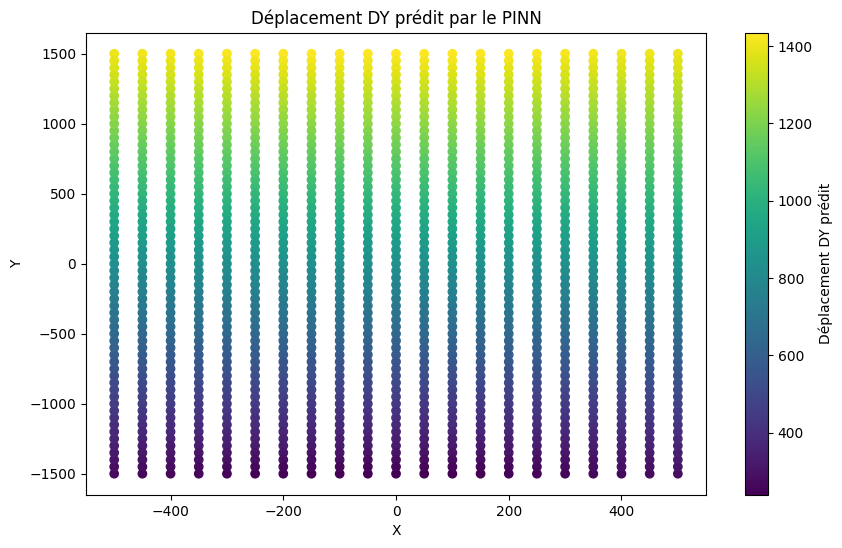

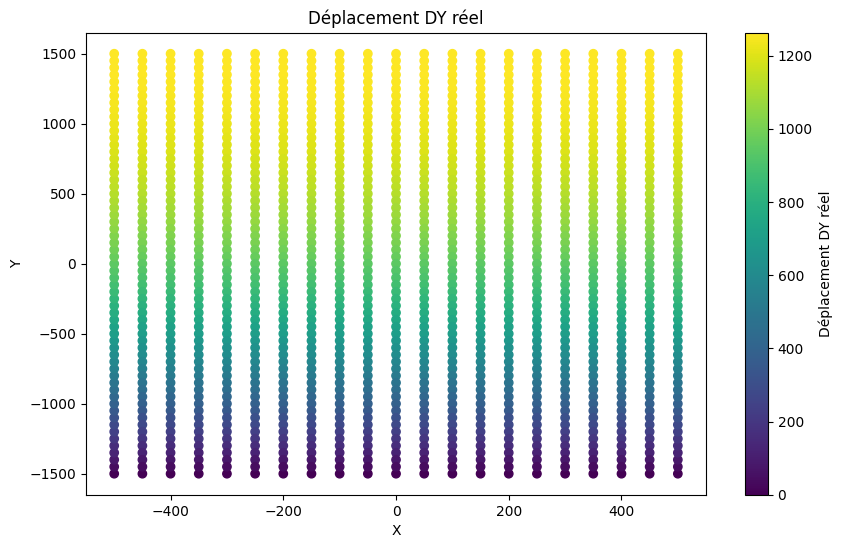

In [14]:
# Prédiction des déplacements DY avec le modèle entraîné
model.eval()
with torch.no_grad():
    dy_pred = model(x_train).numpy() * dy_std + dy_mean  # Dénormaliser les prédictions

# Tracé des résultats avec colorbar
plt.figure(figsize=(10, 6))
scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=dy_pred, cmap='viridis')
plt.colorbar(scatter, label='Déplacement DY prédit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Déplacement DY prédit par le PINN')
plt.show()

# Tracé des déplacements réels pour comparaison
plt.figure(figsize=(10, 6))
scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=displacements_dx, cmap='viridis')
plt.colorbar(scatter, label='Déplacement DY réel')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Déplacement DY réel')
plt.show()


C:\Users\TOUGERON\AppData\Local\Temp\ipykernel_4484\2398624076.py:84: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u[free_nodes] = spsolve(K_free, F_free)


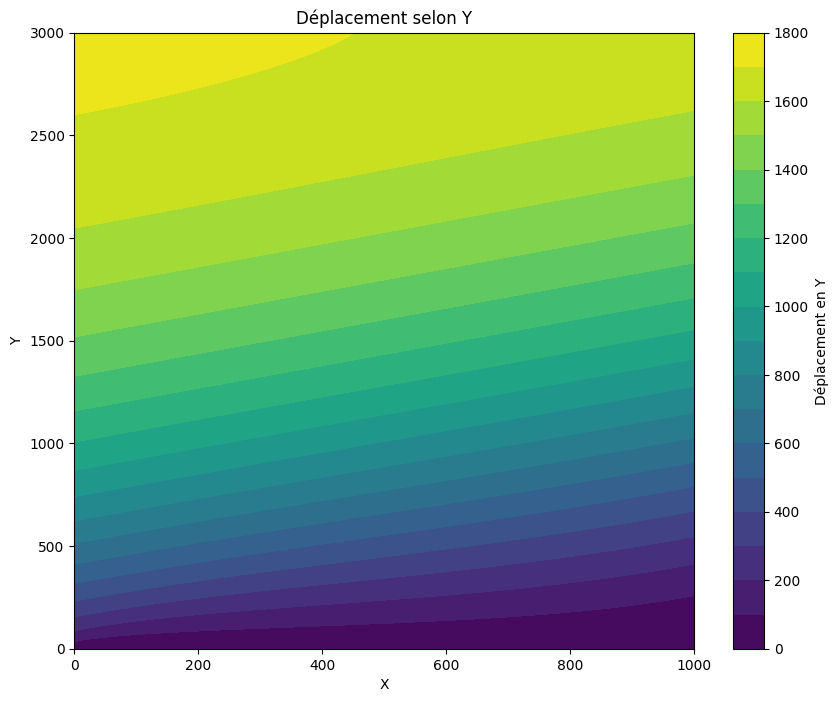

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Paramètres du problème
Lx, Ly = 1000, 3000  # Dimensions du domaine
nx, ny = 100, 100  # Nombre de divisions dans chaque direction
dx, dy = Lx / nx, Ly / ny  # Taille des éléments

# Constantes de Lamé
E = 210e9  # Module de Young en Pascals
nu = 0.3   # Coefficient de Poisson
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))
fy = 100.0e6  # Force appliquée

# Nombre total de noeuds
n_nodes = (nx + 1) * (ny + 1)
n_elements = nx * ny

# Création des noeuds
nodes = np.array([[i * dx, j * dy] for j in range(ny + 1) for i in range(nx + 1)])

# Création des éléments
elements = []
for j in range(ny):
    for i in range(nx):
        n1 = j * (nx + 1) + i
        n2 = n1 + 1
        n3 = n1 + nx + 1
        n4 = n3 + 1
        elements.append([n1, n2, n4, n3])

# Matrices de raideur et vecteur de force
K = lil_matrix((n_nodes, n_nodes))
F = np.zeros(n_nodes)

# Fonction de forme et leurs dérivées pour un élément quadrilatéral
def shape_functions(xi, eta):
    N = 0.25 * np.array([(1 - xi) * (1 - eta),
                         (1 + xi) * (1 - eta),
                         (1 + xi) * (1 + eta),
                         (1 - xi) * (1 + eta)])
    dN_dxi = 0.25 * np.array([[-(1 - eta), (1 - eta), (1 + eta), -(1 + eta)],
                              [-(1 - xi), -(1 + xi), (1 + xi), (1 - xi)]])
    return N, dN_dxi

# Assemblage de la matrice de raideur et du vecteur de force
for element in elements:
    Ke = np.zeros((4, 4))
    Fe = np.zeros(4)
    for xi, eta in [(-1/np.sqrt(3), -1/np.sqrt(3)), (1/np.sqrt(3), -1/np.sqrt(3)), (1/np.sqrt(3), 1/np.sqrt(3)), (-1/np.sqrt(3), 1/np.sqrt(3))]:
        N, dN_dxi = shape_functions(xi, eta)
        J = dN_dxi @ nodes[element]  # J est maintenant (2, 2)
        detJ = np.linalg.det(J)
        dN_dxy = np.linalg.inv(J) @ dN_dxi
        B = np.zeros((3, 4))
        B[0, :] = dN_dxy[0, :]
        B[1, :] = dN_dxy[1, :]
        B[2, :] = dN_dxy[0, :] + dN_dxy[1, :]
        D = np.array([[lambda_ + 2*mu, lambda_, 0],
                      [lambda_, lambda_ + 2*mu, 0],
                      [0, 0, mu]])
        Ke += B.T @ D @ B * detJ
        Fe += N * fy * detJ
    for i in range(4):
        for j in range(4):
            K[element[i], element[j]] += Ke[i, j]
        F[element[i]] += Fe[i]

# Conditions aux limites (encastrement sur le bord y = 0)
fixed_nodes = [i for i in range(n_nodes) if nodes[i, 1] == 0]

# Liste des noeuds libres
free_nodes = [i for i in range(n_nodes) if i not in fixed_nodes]

# Réduction du système linéaire
K_free = K[free_nodes, :][:, free_nodes]
F_free = F[free_nodes]

# Résolution du système linéaire
u = np.zeros(n_nodes)
u[free_nodes] = spsolve(K_free, F_free)

# Affichage des résultats
X, Y = nodes[:, 0].reshape((ny+1, nx+1)), nodes[:, 1].reshape((ny+1, nx+1))
U = u.reshape((ny+1, nx+1))

plt.figure(figsize=(10, 8))
plt.contourf(X, Y, U, 20, cmap='viridis')
plt.colorbar(label='Déplacement en Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Déplacement selon Y')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Définition de l'équation KdV
def kdv_equation(x, t, u, u_t, u_x, u_xxx):
    return u_t + 6*u*u_x + u_xxx

# Génération de données de formation
def initial_condition(x):
    return np.cosh(x)**-2

# Génération de données de la grille
L = 20.0
N = 256
T = 1.0
x = np.linspace(-L/2, L/2, N)
t = np.linspace(0, T, N)
X, T = np.meshgrid(x, t)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]

# Condition initiale
u0 = initial_condition(x)

# Construction du modèle PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, X):
        for i in range(len(self.layers)-1):
            X = torch.tanh(self.layers[i](X))
        return self.layers[-1](X)

# Définition de la perte
def loss(model, X_f, X_u, u):
    X_f.requires_grad = True
    u_pred = model(X_f)
    u_pred_x = torch.autograd.grad(u_pred, X_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 0]
    u_pred_t = torch.autograd.grad(u_pred, X_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 1]
    u_pred_xx = torch.autograd.grad(u_pred_x, X_f, grad_outputs=torch.ones_like(u_pred_x), create_graph=True)[0][:, 0]
    u_pred_xxx = torch.autograd.grad(u_pred_xx, X_f, grad_outputs=torch.ones_like(u_pred_xx), create_graph=True)[0][:, 0]
    
    f_pred = kdv_equation(X_f[:, 0], X_f[:, 1], u_pred, u_pred_t, u_pred_x, u_pred_xxx)
    u_pred_ic = model(X_u)
    loss_u = torch.mean((u - u_pred_ic)**2)
    loss_f = torch.mean(f_pred**2)
    return loss_u + loss_f

# Génération des données de formation
X_f_train = torch.tensor(np.hstack((X_flat, T_flat)), dtype=torch.float32)
X_u_train = torch.tensor(np.hstack((x[:, None], np.zeros_like(x[:, None]))), dtype=torch.float32)
u_train = torch.tensor(u0[:, None], dtype=torch.float32)

# Entraînement du modèle PINN
layers = [2, 50, 50, 50, 1]
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    train_loss = loss(model, X_f_train, X_u_train, u_train)
    train_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

# Prédiction
u_pred = model(X_f_train).detach().numpy().reshape(N, N)

# Affichage des résultats
plt.figure(figsize=(10, 8))
plt.contourf(X, T, u_pred, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution de l\'équation de KdV')
plt.show()
